In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   
    ]),
    
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   
    ]),
}

In [4]:
data_dir = 'hymenoptera_data'
dsets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

In [5]:
dset_loaders = {
    x: torch.utils.data.DataLoader(dsets[x], batch_size = 4, shuffle = True, num_workers=4)
    for x in ['train', 'val']
}

In [6]:
dset_sizes = {
    x: len(dsets[x])
    for x in ['train', 'val']
}

In [7]:
dset_classes = dsets['train'].classes

In [8]:
use_gpu = torch.cuda.is_available()

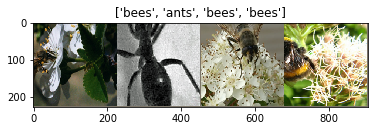

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [dset_classes[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()
    
    best_model = model
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'. format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dset_loaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
            
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m and {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best val accuracy : {:.4f}'.format(best_acc))
    
    return best_model
                

In [11]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return optimizer

In [12]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    figure = plt.figure()
    
    for i,data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)


if use_gpu:
    model_ft = model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1599 Acc: 0.6598
val Loss: 0.0464 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.1291 Acc: 0.7500
val Loss: 0.0472 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.0835 Acc: 0.8689
val Loss: 0.0677 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.0799 Acc: 0.8689
val Loss: 0.0494 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.1037 Acc: 0.8156
val Loss: 0.0920 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.1202 Acc: 0.8320
val Loss: 0.0946 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.1171 Acc: 0.7910
val Loss: 0.0820 Acc: 0.8954

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0902 Acc: 0.8320
val Loss: 0.0620 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.0905 Acc: 0.8361
val Loss: 0.0529 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.0827 Acc: 0.8402
val Loss: 0.0515 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0816 Acc: 0.8689
val Loss: 0.0562 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.0726 Acc: 

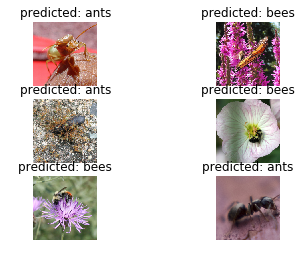

In [16]:
visualize_model(model_ft)

In [17]:
'''
Try to save best model
'''
torch.save(model_ft.state_dict(), 'best_model_ants_bees')